<a href="https://colab.research.google.com/github/nat-tsang/bee_or_wasp_classifier/blob/main/bee_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.models import Sequential,load_model, Model
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses

import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle
!kaggle datasets download -d jerzydziewierz/bee-vs-wasp
!unzip \*.zip  && rm *.zip

In [ ]:
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
DATA = "/content/drive/MyDrive/Kaggle/kaggle_bee_vs_wasp/"
df = pd.read_csv(DATA + 'labels.csv')

In [ ]:
def set_train_type(row):
    if row['is_validation'] == 0 and row['is_final_validation'] == 0:
        return 'train'
    if row['is_validation'] == 1:
        return 'validation'
    return 'test'

df['type'] = df.apply(set_train_type, axis=1)
print('Number values of each type')
df['type'].value_counts()

Number values of each type


train         7939
test          1763
validation    1719
Name: type, dtype: int64

In [ ]:
print('Number values of each label')
df['label'].value_counts()

Number values of each label


wasp      4943
bee       3183
insect    2439
other      856
Name: label, dtype: int64

In [ ]:
# replace \\ for / since using windows/linux env
for index in tqdm(df.index):
  df.loc[index, 'path']=df.loc[index, 'path'].replace('\\', '/')

df.head()

def display_img(row, pos):
  path = row['path'].replace('\\', os.sep)
  path = os.path.join(DATA, path)
  img = cv2.imread(path)
  # standardize img size
  img = cv2.resize(img, (128, 128))
  # set colour to RGB for all imgs
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # disp img with title
  plt.subplot(4, 5, pos)
  plt.imshow(img)
  plt.title(row['label'])
  # rm ticks
  plt.xticks([])
  plt.yticks([])

100%|██████████| 11421/11421 [00:03<00:00, 3495.88it/s]


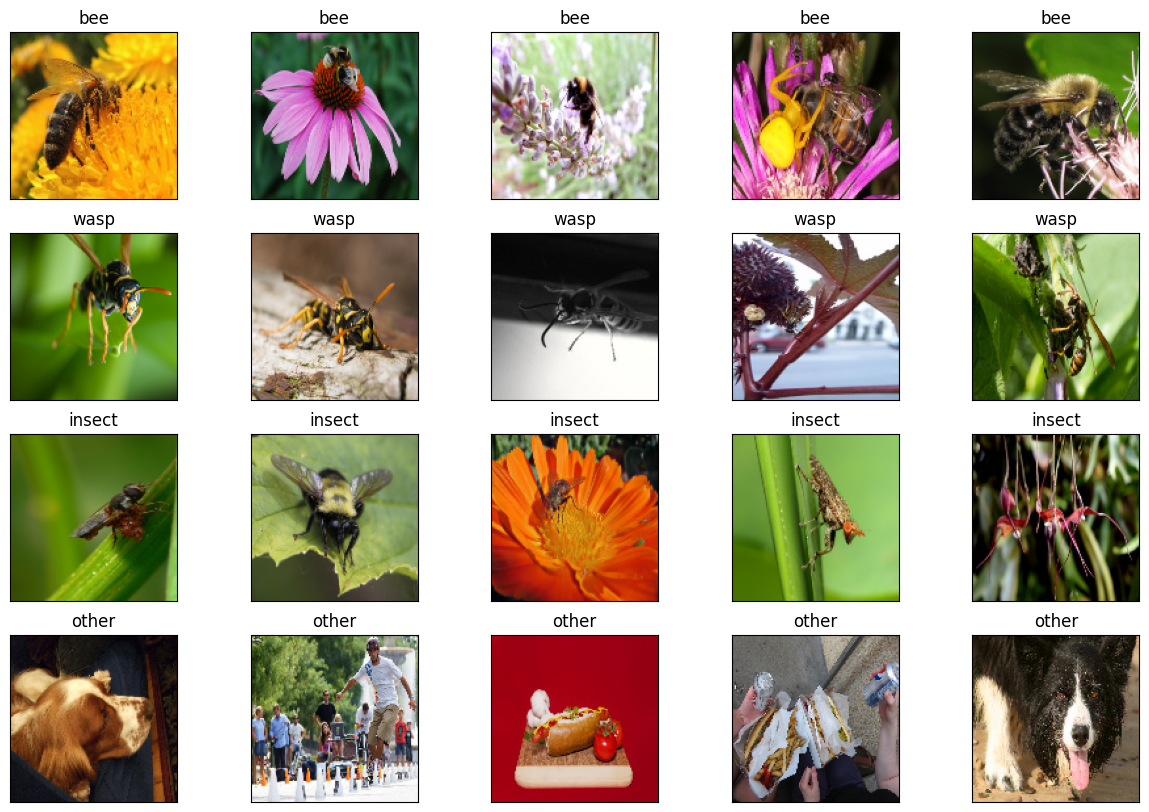

In [ ]:
bee = df.query("(label == 'bee') and (photo_quality == 1)").sample(5, random_state=42)
wasp = df.query("(label == 'wasp') and (photo_quality == 1)").sample(5, random_state=42)
insect = df.query("(label == 'insect') and (photo_quality == 1)").sample(5, random_state=42)
other = df.query("(label == 'other')").sample(5, random_state=42)

plt.figure(figsize=(15,10))
pos=1

for idx, row in bee.iterrows():
  display_img(row, pos)
  pos += 1

for idx, row in wasp.iterrows():
  display_img(row, pos)
  pos += 1

for idx, row in insect.iterrows():
  display_img(row, pos)
  pos += 1

for idx, row in other.iterrows():
  display_img(row, pos)
  pos += 1

plt.show()


In [ ]:
df['path'] = df['path'].str.replace('\\', os.sep)
df['path'].head()

<ipython-input-7-98d77595e2b2>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['path'] = df['path'].str.replace('\\', os.sep)


0    bee1/10007154554_026417cfd0_n.jpg
1    bee1/10024864894_6dc54d4b34_n.jpg
2    bee1/10092043833_7306dfd1f0_n.jpg
3     bee1/1011948979_fc3637e779_w.jpg
4    bee1/10128235063_dca17db76c_n.jpg
Name: path, dtype: object

In [ ]:
train_df = df[df['type'] == 'train']
valid_df = df[df['type'] == 'validation']
test_df = df[df['type'] == 'test']

# size images to same shape and size
TARGET_SIZE = (256, 256)
SEED = 42

In [ ]:
datagen = ImageDataGenerator(rescale=1./255.)

train_datagen = datagen.flow_from_dataframe(train_df,
                                            directory=DATA,
                                            x_col='path',
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           )

valid_datagen = datagen.flow_from_dataframe(valid_df,
                                            directory=DATA,
                                            x_col='path',
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           )

test_datagen = datagen.flow_from_dataframe(test_df,
                                           directory=DATA,
                                           x_col='path',
                                           y_col='label',
                                           target_size=TARGET_SIZE,
                                           seed=42
                                           )


Found 7939 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.


In [ ]:
classes = list(train_datagen.class_indices.keys())
n_classes = len(classes)

In [ ]:
model = Sequential([
    # block 1
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001), input_shape=(256,256,3)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, epsilon=0.005, beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9)),
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),

    # block 2
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, epsilon=0.005, beta_initializer=RandomNormal(mean=0.0, stddev=0.0), gamma_initializer=Constant(value=0.9)),
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),

    # block 3
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, epsilon=0.005, beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9)),
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),

    # block 4
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, epsilon=0.005, beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9)),
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),

    # block 5
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Dense(n_classes, activation='softmax')

])

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(train_datagen,
                    batch_size=32,
                    epochs=50,
                    validation_data=valid_datagen,
                    callbacks=[early_stopping])

Epoch 1/50
249/249 [==============================] - 4238s 17s/step - loss: 2.3865 - accuracy: 0.6429 - val_loss: 2.2491 - val_accuracy: 0.5934
Epoch 2/50
249/249 [==============================] - 68s 274ms/step - loss: 1.9583 - accuracy: 0.7332 - val_loss: 1.9207 - val_accuracy: 0.6312
Epoch 3/50
249/249 [==============================] - 74s 296ms/step - loss: 1.6367 - accuracy: 0.7681 - val_loss: 1.6001 - val_accuracy: 0.7115
Epoch 4/50
249/249 [==============================] - 71s 286ms/step - loss: 1.3852 - accuracy: 0.7899 - val_loss: 1.3188 - val_accuracy: 0.7708
Epoch 5/50
249/249 [==============================] - 68s 272ms/step - loss: 1.1816 - accuracy: 0.8104 - val_loss: 1.1492 - val_accuracy: 0.7615
Epoch 6/50
249/249 [==============================] - 69s 277ms/step - loss: 1.0303 - accuracy: 0.8252 - val_loss: 0.9763 - val_accuracy: 0.8348
Epoch 7/50
249/249 [==============================] - 70s 279ms/step - loss: 0.9076 - accuracy: 0.8312 - val_loss: 0.8976 - val_ac

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model_path="/content/drive/MyDrive/model/mask_model"
model.save(model_path+'.h5')

In [ ]:
# bash
!cd /content/drive/MyDrive/model/js_model
!ls
!type group1-shard1of5.bin group1-shard2of5.bin group1-shard3of5.bin group1-shard4of5.bin group1-shard5of5.bin > group1-shard.bin

drive  sample_data
/bin/bash: line 1: type: group1-shard1of5.bin: not found
/bin/bash: line 1: type: group1-shard2of5.bin: not found
/bin/bash: line 1: type: group1-shard3of5.bin: not found
/bin/bash: line 1: type: group1-shard4of5.bin: not found
/bin/bash: line 1: type: group1-shard5of5.bin: not found
